In [1]:
import torch
import torch.nn as nn
from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

# create the dataset class

In [2]:
class aerial_seg(Dataset):
    def __init__(self,split):
        if split=='train':
            self.items=os.listdir(r'C:\myfiles\building detection\training\new_images')
            self.masks=os.listdir(r'C:\myfiles\building detection\training\new_labels')
        elif split=='validate':
            self.items=os.listdir(r'C:\myfiles\building detection\validation\new_images')
            self.masks=os.listdir(r'C:\myfiles\building detection\validation\new_labels')
        self.split=split
        
    def __len__(self):
        return len(self.masks)   
    
    
    def __getitem__(self,ix):
        temp=ix
        if self.split=='train':
            image=cv2.imread(os.path.join(r'C:\myfiles\building detection\training\new_images',self.items[temp]))
            image=torch.Tensor(image)
            image=torch.permute(image,(2,0,1)).float()
            image=image.to(device)
            mask=cv2.imread(os.path.join(r'C:\myfiles\building detection\training\new_labels',self.masks[temp]),0)
            mask[mask > 0] = 1
            mask=torch.Tensor(mask).long()
            mask=mask.to(device)
            return image,mask
        
        
        
        elif self.split=='validate':
            image=cv2.imread(os.path.join(r'C:\myfiles\building detection\validation\new_images',self.items[temp]))
            image=torch.Tensor(image)
            image=torch.permute(image,(2,0,1)).float()
            image=image.to(device)
            mask=cv2.imread(os.path.join(r'C:\myfiles\building detection\validation\new_labels',self.masks[temp]),0)
            mask[mask > 0] = 1
            mask=torch.Tensor(mask).long()
            mask=mask.to(device)
            return image,mask
        
        
        
        
        

# create datasets and dataloaders

In [3]:
train_ds=aerial_seg('train')
val_ds=aerial_seg('validate')
train_dl=DataLoader(train_ds,batch_size=4,shuffle=True)
val_dl=DataLoader(val_ds,batch_size=1,shuffle=True)


# define conv and transpose convolution function to be used in the model

In [4]:
def conv(input_channels,output_channels):
    return nn.Sequential(
           nn.Conv2d(input_channels,output_channels,kernel_size=3, stride=1, padding=1),
           nn.BatchNorm2d(output_channels),
           nn.ReLU(inplace=True))
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

# create the unet model with vgg16_bn as backbone encoder part

In [5]:
from torchvision.models import vgg16_bn
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=2):
        super().__init__()

        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

# define loss function as cross entropy loss

In [6]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

# define train batch and validate batch functions

In [7]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [8]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 5

In [9]:
#from torchsummary import summary
#summary(model, torch.zeros(1,3,448,448));

# train the model

In [10]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(train_dl)
    for bx, data in enumerate(train_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)

C:\Users\mosta\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


EPOCH: 1.000	trn_loss: 0.218	trn_acc: 0.935	val_loss: 0.092	val_acc: 0.967	(84.07s - 336.28s remaining)
EPOCH: 2.000	trn_loss: 0.106	trn_acc: 0.962	val_loss: 0.073	val_acc: 0.972	(164.52s - 246.79s remaining)
EPOCH: 3.000	trn_loss: 0.082	trn_acc: 0.969	val_loss: 0.357	val_acc: 0.926	(243.35s - 162.23s remaining)
EPOCH: 4.000	trn_loss: 0.081	trn_acc: 0.969	val_loss: 0.062	val_acc: 0.976	(320.99s - 80.25s remaining)
EPOCH: 5.000	trn_loss: 0.070	trn_acc: 0.973	val_loss: 0.060	val_acc: 0.976	(398.28s - 0.00s remaining)


# get any validation image and mask to make predictions on it

In [13]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)

# display the image , the true mask  and the predicted mask

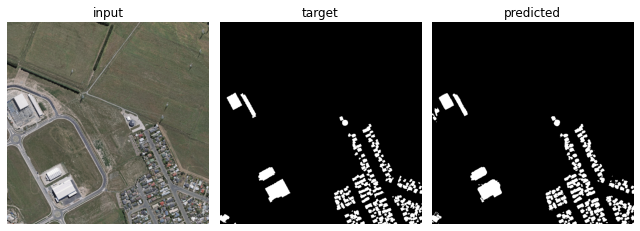

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(9,9))
show(im[0].long().permute(1,2,0), ax=ax[0], title='input')
show(mask.permute(1,2,0).detach().cpu(),ax=ax[1], title='target')
show(_mask.permute(1,2,0).detach().cpu(),ax=ax[2], title='predicted')
plt.tight_layout()
plt.show()